# Awareness Modeling


In [1]:
%matplotlib inline
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import seaborn as sns
from scipy import sparse, stats, spatial
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import NMF, LatentDirichletAllocation


## Import the features from different pickles : 

In [67]:
def stand(mylist):  
    std_scaler = StandardScaler().fit(np.array(mylist).reshape(-1, 1))
    return std_scaler.transform(np.array(mylist).reshape(-1, 1)) 

def stand_df(df):
    maxvalue = df.replace(np.inf,0.0).max().max()
    infvalreplace = 2 * maxvalue
    df.replace(np.inf,infvalreplace,inplace=True)
    df.replace(np.nan,infvalreplace,inplace=True)
    myindex = df.index
    mycolumns = df.columns
    mylist = df.as_matrix()
    myshape = np.shape(mylist)
    std_scaler = StandardScaler().fit(np.array(mylist).reshape(-1, 1))
    scaled_list = std_scaler.transform(np.array(mylist).reshape(-1, 1)).reshape(myshape)   
    return pd.DataFrame(scaled_list,index=myindex,columns=mycolumns)

In [92]:
c_data = pickle.load(open('../DataEnriching/data.pickle','rb'))
countries = c_data.index.tolist()
c_data = c_data.reset_index()
c_data = c_data.set_index("ISO2")
# Keep only relevant fields 
c_data = c_data[['ISO2','POP', 'area', 'gdp', 'gdp_capita', 'pop_pov', 'region']]


lang_feature_df = pd.read_pickle('../LinkingLanguages/stand_country_dist_languages.pkl')
fligh_routes_df = pd.read_pickle('../GeoMetrics/flight_routes_std.pickle')
hop_distance_df = pd.read_pickle('../GeoMetrics/hop_distance_std.pickle')
neighbor_influence_df = pd.read_pickle('../GeoMetrics/neighbor_influence.pickle')
dist_feature_df = pd.read_pickle('../GeoMetrics/real_distance_std.pickle')
religion_and_more_df = pd.read_pickle('../DataEnriching/rel_distance_df.pickle')
religion_and_more_df = stand_df(religion_and_more_df)
religion_and_more_df = religion_and_more_df - religion_and_more_df.min().min()

# shift the standardized values :
lang_feature_df = lang_feature_df - lang_feature_df.min().min()
fligh_routes_df = fligh_routes_df - fligh_routes_df.min().min()
hop_distance_df = hop_distance_df - hop_distance_df.min().min()
neighbor_influence_df = neighbor_influence_df - neighbor_influence_df.min().min()
dist_feature_df = dist_feature_df - dist_feature_df.min().min()
#religion_and_more_df = religion_and_more_df - religion_and_more_df.min().min()


#carefull the number of coutries is not the same in every pickle.
features_df = pd.concat([lang_feature_df,
                         fligh_routes_df,
                         hop_distance_df,
                         neighbor_influence_df,
                         dist_feature_df],axis=1)

features_df.sort_index(axis=1,inplace=True)

features_df.columns = features_df.columns.droplevel(level = 0)
features_df = pd.concat([features_df, religion_and_more_df], axis=1)

features_df[features_df.isnull().any(axis=1)].head(10)

,AD,AE,AF,AG,AI,AL,AM,AO,AQ,AR,...,VG,VI,VN,VU,WF,WS,YE,ZA,ZM,ZW
UM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.493388,1.474674,1.225396,1.495521,1.715195,1.52471,1.207935,1.300991,1.545567,1.53366


In [93]:
# convert every Nan to a 0 
features_df.fillna(value=0,inplace=True)
# replace inf by a large number :
features_df.replace(np.inf, 1E5,inplace=True)

#features_df.loc[:,'gov_type_num'] = features_df.loc[:,'gov_type_num'] - features_df.loc[:,'gov_type_num'].min()
#features_df.loc[:,'area'] = features_df.loc[:,'area'] - features_df.loc[:,'area'].min()
#features_df.index.is_unique

#to_standadize = ['2016_gdp_capita','POP','area']
#for i in to_standadize:
#    
#    features_df.loc[:,(i)] = stand(list(features_df.loc[:,(i)]))
#    features_df.loc[:,(i)] -=  features_df.loc[:,(i)].min().min()

features_df.head(20)

,AD,AE,AF,AG,AI,AL,AM,AO,AQ,AR,...,VG,VI,VN,VU,WF,WS,YE,ZA,ZM,ZW
AD,100000.000000,100000.000000,100000.000000,0.119521,0.243244,100000.000000,100000.000000,100000.000000,100000.0,100000.0,...,0.862832,2.575238,2.441062,0.866517,1.206716,0.915975,1.716053,0.454804,2.616480,2.609464
AE,100000.000000,100000.000000,0.096698,100000.000000,100000.000000,100000.000000,0.024626,0.024626,100000.0,100000.0,...,1.194543,2.710030,2.612339,1.197432,1.525240,1.230872,1.255804,0.972257,2.741310,2.734322
AF,100000.000000,2.504397,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.0,...,2.857311,1.471653,1.220546,2.858426,2.979247,2.873806,1.218927,2.753572,1.542684,1.530756
AG,0.292734,100000.000000,100000.000000,100000.000000,0.292734,100000.000000,100000.000000,100000.000000,100000.0,100000.0,...,0.033845,2.460623,2.574394,0.055229,1.384922,0.146233,1.909949,0.387058,2.443685,2.439571
AI,4.152905,100000.000000,100000.000000,2.074351,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.0,...,0.050286,2.466333,2.594000,0.078617,1.434951,0.153756,1.935923,0.446509,2.443410,2.438111
AL,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.0,...,1.103361,2.651452,2.537097,1.101535,1.288939,1.131696,1.332125,0.812311,2.699132,2.698836
AM,100000.000000,0.447657,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.0,...,2.456945,0.591283,1.136871,2.459373,2.949699,2.462592,2.060699,2.536426,0.332234,0.238809
AO,100000.000000,0.712540,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.0,...,2.500119,0.269050,0.625871,2.493288,2.580052,2.487915,1.847019,2.472921,0.520096,0.609225
AQ,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.0,...,1.493388,1.474674,1.225396,1.495521,1.715195,1.524710,1.207935,1.300991,1.545567,1.533660
AR,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.0,...,2.767867,0.991518,1.045760,2.751708,2.439547,2.732608,2.050256,2.681908,1.250916,1.360277


## Applying the NMF

In [94]:
features_mat = features_df.as_matrix()


In [104]:
n_samples = np.shape(features_mat)[1]
n_features = len(features_df.columns)
n_components = round(np.shape(features_mat)[1]/300)

In [105]:
W = LatentDirichletAllocation(n_components=n_components, max_iter=20,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0).fit_transform(features_mat)

In [97]:
np.shape(W)

(248, 212)

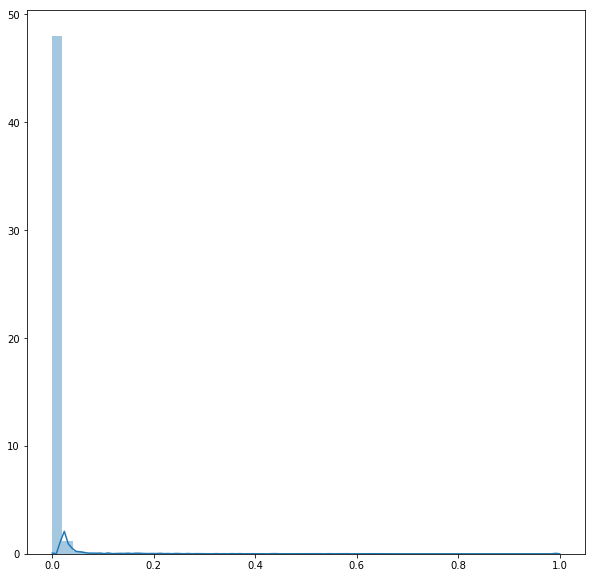

In [98]:
plt.figure(figsize=[10,10])
sns.distplot(W.flatten())

## Weight Matrix and Graph

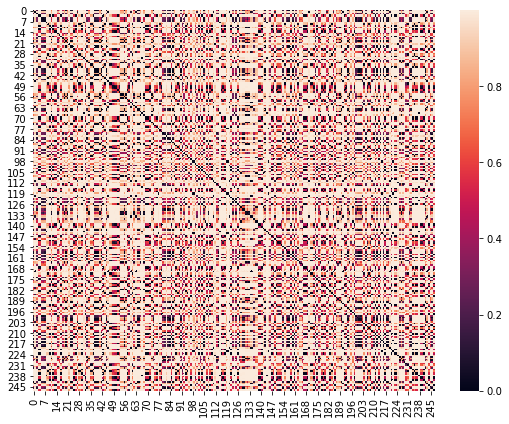

In [99]:
distances = spatial.distance.squareform(spatial.distance.pdist(W,'cosine')) # W
plt.figure(figsize=[9,7])
sns.heatmap(distances)

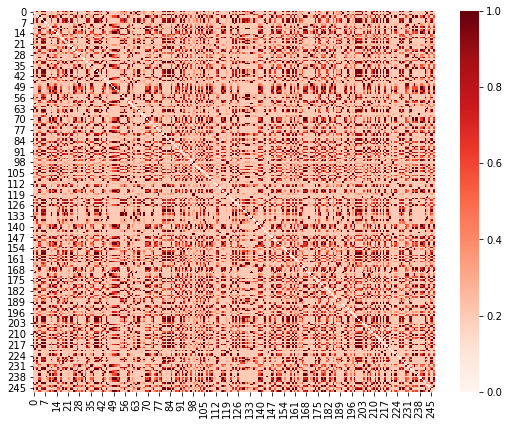

In [100]:
kernel_width = np.mean(distances)#distances.mean()

def kernel(x):
    return np.exp(- np.power(x/kernel_width,2))

# applying the kernel to the distances matrix :
weights = kernel(distances)
# setting the diagonal (self-loops) weights to 0 :
weights[range(len(weights)),range(len(weights))] = 0

# displaying a subset of the weights matrix :
plt.figure(figsize=[9,7])
sns.heatmap(weights,cmap="Reds")

In [101]:
weights_df = pd.DataFrame(weights,columns=countries,index=countries)

In [102]:
country = 'France'
weights_df[country].loc[weights_df[country] >= 0.99].sort_values(ascending=False)

DR Congo                     1.000000
Marshall Islands             1.000000
Turks and Caicos Islands     0.999999
Switzerland                  0.999999
Bahamas                      0.999998
New Caledonia                0.999994
Guinea-Bissau                0.999992
Malaysia                     0.999986
China                        0.999986
Bahrain                      0.999967
Rwanda                       0.999943
Guadeloupe                   0.999918
Guatemala                    0.999879
Cocos (Keeling) Islands      0.999877
Egypt                        0.999847
Libya                        0.999829
Mayotte                      0.999829
Seychelles                   0.999803
Canada                       0.999795
Burkina Faso                 0.999780
Tajikistan                   0.999773
Somalia                      0.999600
Wallis and Futuna            0.999590
Ecuador                      0.999540
Singapore                    0.998480
Cyprus                       0.997081
Aruba       

In [103]:
weights_df

,Aruba,Afghanistan,Angola,Anguilla,Åland Islands,Albania,Andorra,United Arab Emirates,Argentina,Armenia,...,British Virgin Islands,United States Virgin Islands,Vietnam,Vanuatu,Wallis and Futuna,Samoa,Yemen,South Africa,Zambia,Zimbabwe
Aruba,0.000000,0.232659,0.919501,0.196051,0.196620,0.991072,0.987961,0.997948,0.195738,0.195742,...,0.196096,0.198698,0.199275,0.196645,0.999722,0.333799,0.199143,0.666681,0.951109,0.198800
Afghanistan,0.232659,0.000000,0.215563,0.195769,0.195773,0.262947,0.275703,0.255284,0.195738,0.195738,...,0.196153,0.195850,0.195885,0.195784,0.221416,0.997477,0.195880,0.244330,0.210063,0.195843
Angola,0.919501,0.215563,0.000000,0.196982,0.198719,0.854949,0.836786,0.894854,0.195738,0.195741,...,0.197010,0.198056,0.198493,0.197253,0.922991,0.308661,0.198408,0.899680,0.988247,0.198164
Anguilla,0.196051,0.195769,0.196982,0.000000,0.999926,0.196075,0.196052,0.196062,0.265598,0.276790,...,0.195740,0.603265,0.607698,0.999472,0.196008,0.195784,0.608900,0.197475,0.197009,0.605847
Åland Islands,0.196620,0.195773,0.198719,0.999926,0.000000,0.196569,0.196513,0.196590,0.262384,0.264857,...,0.195743,0.626444,0.630218,0.999898,0.196582,0.195891,0.629743,0.199628,0.198828,0.630599
Albania,0.991072,0.262947,0.854949,0.196075,0.196569,0.000000,0.999488,0.996000,0.195738,0.195743,...,0.196219,0.198525,0.199055,0.196642,0.973463,0.310736,0.198884,0.703382,0.853363,0.198462
Andorra,0.987961,0.275703,0.836786,0.196052,0.196513,0.999488,0.000000,0.997370,0.195738,0.195742,...,0.196195,0.198388,0.198919,0.196590,0.970724,0.308039,0.198783,0.715104,0.853623,0.198397
United Arab Emirates,0.997948,0.255284,0.894854,0.196062,0.196590,0.996000,0.997370,0.000000,0.195738,0.195742,...,0.196161,0.198601,0.199157,0.196656,0.994428,0.332383,0.199066,0.759755,0.931024,0.198720
Argentina,0.195738,0.195738,0.195738,0.265598,0.262384,0.195738,0.195738,0.195738,0.000000,0.233201,...,0.997834,0.309074,0.310429,0.272023,0.195738,0.195738,0.310789,0.195738,0.195738,0.310580
Armenia,0.195742,0.195738,0.195741,0.276790,0.264857,0.195743,0.195742,0.195742,0.233201,0.000000,...,0.195738,0.381470,0.399307,0.278891,0.195741,0.195738,0.393370,0.195740,0.195740,0.380783
